# WBGT in observations (ISIMIP3a): country-level results

Obsclim 2000-2019. Could compare this with models see places where biggest difference in e.g. in nAHD 

To do:
- put back in countries that are lost because too small? get closest pixel
- fix coastal pixels
- try with ISIMIP country masks, maybe you dont lose these places...

In [1]:
# necessary: netcdf4-python, regionmask, (xarray, geopandas), cartopy, openpyxl, (statsmodels?)

import numpy as np
import pandas as pd
import os, glob, re 
import math
import xarray as xr
import geopandas as gpd
import regionmask as regionmask
import dask
import matplotlib.pyplot as plt
import netCDF4

%matplotlib inline

#plotting
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# import my variables settings functions from other scripts
from settings import *

# import fxns 
from functions import *
from utils import *
from plotscript import *

# import other packages/modules 

sys.path.append('../population/') # make this a module i can pip install and import ! 
from population_demographics_climate import * # move / rename this when good ! --> change to import demographics4climate as d4c


/apps/brussel/RL8/broadwell/software/Python/3.10.4-GCCcore-11.3.0/lib/python3.10/site-packages/paramiko/transport.py:236: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,
/apps/brussel/RL8/broadwell/software/statsmodels/0.13.1-foss-2022a/lib/python3.10/site-packages/statsmodels/compat/pandas.py:65: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex


In [2]:
start_message() # change indir to indir obs and datasets to datasets obs in start message

flags: {'models': 'ISIMIP3a', 'experiment': 'obsclim', 'metric': 'WBGT', 'method': 'shift_fit', 'time_method': None, 'chunk_version': 0, 'var': 'wbgt'}
var: wbgt
VARs: None
indir_p: /data/brussel/vo/000/bvo00012/data/dataset/ISIMIP/ISIMIP3b/InputData/climate/atmosphere/bias-adjusted/global/daily/
indir_s: /data/brussel/vo/000/bvo00012/data/dataset/ISIMIP/ISIMIP3b/SecondaryInputData/climate/atmosphere/bias-adjusted/global/daily/
indir_obs: /data/brussel/vo/000/bvo00012/data/dataset/ISIMIP/ISIMIP3a/InputData/climate/atmosphere/obsclim/global/daily/historical/
indir_counterclim: /data/brussel/vo/000/bvo00012/data/dataset/ISIMIP/ISIMIP3a/InputData/climate/atmosphere/counterclim/global/daily/historical/
GCMs: ['CanESM5', 'CNRM-CM6-1', 'GFDL-ESM4', 'IPSL-CM6A-LR', 'MIROC6', 'MRI-ESM2-0']
datasets: ['GSWP3-W5E5', '20CRv3', '20CRv3-ERA5', '20CRv3-W5E5']
lat_chunk: 90
lon_chunk: 120
time_chunk: -1
outdirs: /data/brussel/vo/000/bvo00012/vsc10419/attr-hw/output
figdirs: /data/brussel/vo/000/bvo00

In [3]:
from dask.distributed import Client 
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 2
Total threads: 2,Total memory: 40.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:33913,Workers: 2
Dashboard: http://127.0.0.1:8787/status,Total threads: 2
Started: Just now,Total memory: 40.00 GiB
Comm: tcp://127.0.0.1:38803,Total threads: 1
Dashboard: http://127.0.0.1:33355/status,Memory: 20.00 GiB
Nanny: tcp://127.0.0.1:32875,


In [4]:
figdir = os.path.join(figdirs, 'fig_apr24-isimip3a-wbgt')


# Open data obsclim and models 

In [5]:
datasets_sel = datasets[0], datasets[2], datasets[3]

In [6]:
nyrs=20

da_p28_obs, da_p30_obs = [ open_all_wbgt_summary(GCMs=datasets_sel,
                            metric='WBGT',
                            open_what=open_what,
                            outdirname='output_apr24-9139513',
                            experiment='obsclim',
                            period='present',
                            observations=True,
                            nyrs=nyrs).rename(name) for open_what, name in zip(['pctl28','pctl30'], ['gt28','gt30']) ]

da_mean_obs, da_min_obs, da_max_obs, da_std_obs = [ open_all_wbgt_summary(GCMs=datasets_sel,
                            metric='WBGT',
                            open_what=open_what,
                            outdirname='output_apr24-9139513',
                            experiment='obsclim',
                            period='present',
                            observations=True,
                            nyrs=nyrs).rename(name) \
                                                   for  open_what, name in zip(
                                                                            ['timmean','timmin', 'timmax', 'timstd'], 
                                                                            ['wbgt_mean','wbgt_min', 'wbgt_max', 'wbgt_std']) ] 



In [7]:


da_p28_mod, da_p30_mod = [ open_all_wbgt_summary(GCMs=GCMs,
                            metric='WBGT',
                            open_what=open_what,
                            outdirname='output_apr24-9139513',
                            experiment=None,
                            period='present',
                            observations=False,
                            nyrs=nyrs).rename(name) for open_what, name in zip(['pctl28','pctl30'], ['gt28','gt30']) ]

da_mean_mod, da_min_mod, da_max_mod, da_std_mod = [ open_all_wbgt_summary(GCMs=GCMs,
                            metric='WBGT',
                            open_what=open_what,
                            outdirname='output_apr24-9139513',
                            experiment=None,
                            period='present',
                            observations=False,
                            nyrs=nyrs).rename(name) \
                                                   for  open_what, name in zip(
                                                                            ['timmean','timmin', 'timmax', 'timstd'], 
                                                                            ['wbgt_mean','wbgt_min', 'wbgt_max', 'wbgt_std']) ] 



## country-level averages obsclim: maybe should do pop-weighted average or area weighted average instead of overall average!

In [8]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world

,pop_est,continent,name,iso_a3,gdp_md_est,geometry
0,889953.0,Oceania,Fiji,FJI,5496,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000..."
1,58005463.0,Africa,Tanzania,TZA,63177,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982..."
2,603253.0,Africa,W. Sahara,ESH,907,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948..."
3,37589262.0,North America,Canada,CAN,1736425,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742..."
4,328239523.0,North America,United States of America,USA,21433226,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000..."
...,...,...,...,...,...,...
172,6944975.0,Europe,Serbia,SRB,51475,"POLYGON ((18.82982 45.90887, 18.82984 45.90888..."
173,622137.0,Europe,Montenegro,MNE,5542,"POLYGON ((20.07070 42.58863, 19.80161 42.50009..."
174,1794248.0,Europe,Kosovo,-99,7926,"POLYGON ((20.59025 41.85541, 20.52295 42.21787..."
175,1394973.0,North America,Trinidad and Tobago,TTO,24269,"POLYGON ((-61.68000 10.76000, -61.10500 10.890..."


In [9]:
d_countries = preprocess_all_country_population_data()


interpolating cohort sizes per country
after interpolation and mean-preserving correction there are some neg numbers in 10, Azerbaijan, setting them to zero
after interpolation and mean-preserving correction there are some neg numbers in 98, Libya, setting them to zero
after interpolation and mean-preserving correction there are some neg numbers in 136, Papua New Guinea, setting them to zero
Aruba small, population not calculated
Antigua and Barbuda small, population not calculated
Bahrain small, population not calculated
Barbados small, population not calculated
Federated States of Micronesia small, population not calculated
Grenada small, population not calculated
Guam small, population not calculated
Saint Lucia small, population not calculated
Macao small, population not calculated
Maldives small, population not calculated
Malta small, population not calculated
Singapore small, population not calculated
Tonga small, population not calculated


In [10]:
d_countries.keys()

dict_keys(['info_pop', 'borders', 'population_map', 'birth_years', 'life_expectancy_5', 'cohort_size', 'mask'])

In [11]:
gdf_countries = d_countries['borders'].reset_index()
gdf_countries
# check what countries are missing! (see my old notebooks for this maybe)

,name,geometry,abbreviation,region
0,Aruba,"POLYGON ((-69.99694 12.57758, -69.93639 12.531...",ABW,Latin America & Caribbean
1,Afghanistan,"POLYGON ((74.54235 37.02167, 74.54742 37.01567...",AFG,South Asia
2,Angola,"MULTIPOLYGON (((13.07370 -4.63532, 13.06533 -4...",AGO,Sub-Saharan Africa
3,Albania,"POLYGON ((20.56715 41.87318, 20.54172 41.86158...",ALB,Europe & Central Asia
4,United Arab Emirates,"MULTIPOLYGON (((56.27906 25.62745, 56.30030 25...",ARE,Middle East & North Africa
...,...,...,...,...
186,Samoa,"MULTIPOLYGON (((-172.20104 -13.59254, -172.197...",WSM,East Asia & Pacific
187,Yemen,"MULTIPOLYGON (((51.97861 18.99564, 51.98569 18...",YEM,Middle East & North Africa
188,South Africa,"MULTIPOLYGON (((19.98145 -24.75249, 19.98641 -...",ZAF,Sub-Saharan Africa
189,Zambia,"POLYGON ((32.92086 -9.40790, 32.92303 -9.46629...",ZMB,Sub-Saharan Africa


<AxesSubplot:>

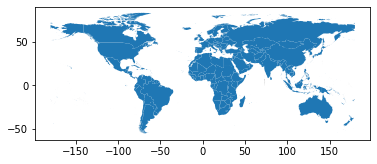

In [12]:
gdf_countries.plot()

In [13]:
da = da_p28_obs.isel(model=0)  * 365 # number of days crossing threshold in w5e5
da

<xarray.DataArray 'gt28' (time: 1, lat: 360, lon: 720)>
array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]], dtype=float32)
Coordinates:
  * lon      (lon) float32 -179.8 -179.2 -178.8 -178.2 ... 178.8 179.2 179.8
  * lat      (lat) float32 89.75 89.25 88.75 88.25 ... -88.75 -89.25 -89.75
    model    <U11 'GSWP3-W5E5'
Dimensions without coordinates: time

In [14]:
countries_mask=regionmask.mask_3D_geopandas(
        gdf_countries,
        da.lon,
        da.lat,
        drop=True
    )
countries_mask

<xarray.DataArray 'mask' (region: 178, lat: 360, lon: 720)>
array([[[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],

       [[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],

       [[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
...
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],

       [[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],

       [[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]]])
Coordinates:
  * lat      (lat) float32 89.75 89.25 88.75 88.25 ... -88.75 -89.25 -89.75
    model    <U11 'GSWP3-W5E5'
  * lon      (lon) float32 -179.8 -179.2 -178.8 -178.2 ... 178.8 179.2 179.8
  * region   (region) int64 1 2 3 4 5 6 8 9 ... 183 184 185 186 187 188 189 190

In [15]:
da_masked=da.where(countries_mask)

In [16]:
da_grouped_mean=da_masked.mean(['lat','lon']).rename('mean_ndays_gt28')
da_grouped_mean

<xarray.DataArray 'mean_ndays_gt28' (time: 1, region: 178)>
array([[1.61557331e+01, 6.24629860e+01, 2.29426193e+00, 1.16459366e+02,
        1.62861328e+01, 9.41278362e+00, 4.71944656e+01, 2.21643075e-01,
        1.38127613e+01, 5.92094517e+00, 1.02870725e-01, 1.98660080e+02,
        1.67005386e+02, 1.70382248e+02, 1.09414864e+00, 5.05653687e+01,
        1.17627764e+00, 0.00000000e+00, 1.41311554e+02, 1.27734161e+02,
        1.63835419e+02, 2.02811081e+02, 2.22001781e+01, 7.30687332e+01,
        1.26821663e+02, 2.61809770e-02, 5.29049411e-02, 4.34485031e-03,
        1.31909256e+01, 1.85063248e+02, 1.07967049e+02, 1.59310486e+02,
        1.20137253e+02, 1.75306946e+02, 0.00000000e+00, 0.00000000e+00,
        1.91572098e+02, 1.18810921e+02, 1.05427790e+01, 4.73360009e-02,
        3.43679972e-02, 1.42652298e+02, 0.00000000e+00, 5.46188393e+01,
        1.99735699e+01, 1.22443199e+02, 1.70891266e+01, 1.36775543e+02,
        1.21967161e+00, 0.00000000e+00, 5.56681404e+01, 0.00000000e+00,
        3.24527740e+01, 5.27776814e+00, 1.38840027e+02, 0.00000000e+00,
        1.82541633e+00, 1.89683716e+02, 1.52273270e+02, 1.73664383e+02,
        1.18945801e+02, 8.92555237e+01, 2.10913229e+00, 1.18336899e+02,
        1.59919571e+02, 9.87823410e+01, 7.80636826e+01, 1.16919923e+00,
        6.46403427e+01, 4.56354141e-01, 2.34560043e+02, 1.46453003e+02,
        0.00000000e+00, 3.02725010e+01, 5.22159996e+01, 0.00000000e+00,
        2.05958920e+01, 7.18973160e-01, 3.97127991e+01, 1.30955753e+01,
...
        1.01427048e+02, 2.27117185e-02, 1.09296814e+02, 1.11937187e+02,
        1.20750630e+00, 6.26493990e-01, 6.90273514e+01, 8.85928116e+01,
        1.15920601e+01, 3.58587723e+01, 1.29250153e+02, 3.50048981e+01,
        1.03262603e+00, 8.72070999e+01, 1.53488373e+02, 7.42268143e+01,
        3.60863954e-02, 0.00000000e+00, 5.73607101e+01, 0.00000000e+00,
        2.69337864e+01, 1.08067101e+02, 8.60264969e+01, 1.30393173e+02,
        1.40302292e+02, 2.87942047e+02, 8.47904198e-03, 2.23180447e+01,
        1.73817122e+00, 5.42311490e-01, 8.92191772e+01, 1.70383301e+01,
        0.00000000e+00, 1.52212418e+02, 5.28728783e-01, 4.68543731e-02,
        1.27412724e+00, 3.47945404e+01, 1.03034439e+02, 1.69915710e+02,
        1.06231781e+02, 2.07697754e+02, 1.23833931e+02, 1.54300446e+02,
        1.11329997e+00, 2.10191193e+02, 0.00000000e+00, 1.01393059e+02,
        1.79876797e-02, 1.83207855e-01, 0.00000000e+00, 3.84336777e+01,
        3.62660065e+01, 9.87773438e+01, 1.94935944e+02, 2.19027023e+02,
        3.42221761e+00, 6.44532776e+00, 1.01680359e+02, 9.51098557e+01,
        3.34186363e+01, 5.01871634e+00, 3.20498734e+01, 9.22813110e+01,
        1.72688752e-01, 5.87312031e+00, 1.42362738e+01, 5.79087925e+00,
        0.00000000e+00, 1.76480316e+02, 0.00000000e+00, 1.38493301e+02,
        4.79671478e+00, 0.00000000e+00, 3.34530487e+01, 1.74173393e+01,
        7.14745407e+01, 4.52456741e+01]], dtype=float32)
Coordinates:
    model    <U11 'GSWP3-W5E5'
  * region   (region) int64 1 2 3 4 5 6 8 9 ... 183 184 185 186 187 188 189 190
Dimensions without coordinates: time

In [17]:
da_grouped_mean

<xarray.DataArray 'mean_ndays_gt28' (time: 1, region: 178)>
array([[1.61557331e+01, 6.24629860e+01, 2.29426193e+00, 1.16459366e+02,
        1.62861328e+01, 9.41278362e+00, 4.71944656e+01, 2.21643075e-01,
        1.38127613e+01, 5.92094517e+00, 1.02870725e-01, 1.98660080e+02,
        1.67005386e+02, 1.70382248e+02, 1.09414864e+00, 5.05653687e+01,
        1.17627764e+00, 0.00000000e+00, 1.41311554e+02, 1.27734161e+02,
        1.63835419e+02, 2.02811081e+02, 2.22001781e+01, 7.30687332e+01,
        1.26821663e+02, 2.61809770e-02, 5.29049411e-02, 4.34485031e-03,
        1.31909256e+01, 1.85063248e+02, 1.07967049e+02, 1.59310486e+02,
        1.20137253e+02, 1.75306946e+02, 0.00000000e+00, 0.00000000e+00,
        1.91572098e+02, 1.18810921e+02, 1.05427790e+01, 4.73360009e-02,
        3.43679972e-02, 1.42652298e+02, 0.00000000e+00, 5.46188393e+01,
        1.99735699e+01, 1.22443199e+02, 1.70891266e+01, 1.36775543e+02,
        1.21967161e+00, 0.00000000e+00, 5.56681404e+01, 0.00000000e+00,
        3.24527740e+01, 5.27776814e+00, 1.38840027e+02, 0.00000000e+00,
        1.82541633e+00, 1.89683716e+02, 1.52273270e+02, 1.73664383e+02,
        1.18945801e+02, 8.92555237e+01, 2.10913229e+00, 1.18336899e+02,
        1.59919571e+02, 9.87823410e+01, 7.80636826e+01, 1.16919923e+00,
        6.46403427e+01, 4.56354141e-01, 2.34560043e+02, 1.46453003e+02,
        0.00000000e+00, 3.02725010e+01, 5.22159996e+01, 0.00000000e+00,
        2.05958920e+01, 7.18973160e-01, 3.97127991e+01, 1.30955753e+01,
...
        1.01427048e+02, 2.27117185e-02, 1.09296814e+02, 1.11937187e+02,
        1.20750630e+00, 6.26493990e-01, 6.90273514e+01, 8.85928116e+01,
        1.15920601e+01, 3.58587723e+01, 1.29250153e+02, 3.50048981e+01,
        1.03262603e+00, 8.72070999e+01, 1.53488373e+02, 7.42268143e+01,
        3.60863954e-02, 0.00000000e+00, 5.73607101e+01, 0.00000000e+00,
        2.69337864e+01, 1.08067101e+02, 8.60264969e+01, 1.30393173e+02,
        1.40302292e+02, 2.87942047e+02, 8.47904198e-03, 2.23180447e+01,
        1.73817122e+00, 5.42311490e-01, 8.92191772e+01, 1.70383301e+01,
        0.00000000e+00, 1.52212418e+02, 5.28728783e-01, 4.68543731e-02,
        1.27412724e+00, 3.47945404e+01, 1.03034439e+02, 1.69915710e+02,
        1.06231781e+02, 2.07697754e+02, 1.23833931e+02, 1.54300446e+02,
        1.11329997e+00, 2.10191193e+02, 0.00000000e+00, 1.01393059e+02,
        1.79876797e-02, 1.83207855e-01, 0.00000000e+00, 3.84336777e+01,
        3.62660065e+01, 9.87773438e+01, 1.94935944e+02, 2.19027023e+02,
        3.42221761e+00, 6.44532776e+00, 1.01680359e+02, 9.51098557e+01,
        3.34186363e+01, 5.01871634e+00, 3.20498734e+01, 9.22813110e+01,
        1.72688752e-01, 5.87312031e+00, 1.42362738e+01, 5.79087925e+00,
        0.00000000e+00, 1.76480316e+02, 0.00000000e+00, 1.38493301e+02,
        4.79671478e+00, 0.00000000e+00, 3.34530487e+01, 1.74173393e+01,
        7.14745407e+01, 4.52456741e+01]], dtype=float32)
Coordinates:
    model    <U11 'GSWP3-W5E5'
  * region   (region) int64 1 2 3 4 5 6 8 9 ... 183 184 185 186 187 188 189 190
Dimensions without coordinates: time

In [18]:
df_zonalstats = da_grouped_mean.to_dataframe().droplevel(0).drop(columns=['model'])
df_zonalstats

,mean_ndays_gt28
region,
1,16.155733
2,62.462986
3,2.294262
4,116.459366
5,16.286133
...,...
186,0.000000
187,33.453049
188,17.417339


In [19]:
gdf_zonalstats = gdf_countries.join(df_zonalstats, how='outer')
gdf_zonalstats

,name,geometry,abbreviation,region,mean_ndays_gt28
0,Aruba,"POLYGON ((-69.99694 12.57758, -69.93639 12.531...",ABW,Latin America & Caribbean,NaN
1,Afghanistan,"POLYGON ((74.54235 37.02167, 74.54742 37.01567...",AFG,South Asia,16.155733
2,Angola,"MULTIPOLYGON (((13.07370 -4.63532, 13.06533 -4...",AGO,Sub-Saharan Africa,62.462986
3,Albania,"POLYGON ((20.56715 41.87318, 20.54172 41.86158...",ALB,Europe & Central Asia,2.294262
4,United Arab Emirates,"MULTIPOLYGON (((56.27906 25.62745, 56.30030 25...",ARE,Middle East & North Africa,116.459366
...,...,...,...,...,...
186,Samoa,"MULTIPOLYGON (((-172.20104 -13.59254, -172.197...",WSM,East Asia & Pacific,0.000000
187,Yemen,"MULTIPOLYGON (((51.97861 18.99564, 51.98569 18...",YEM,Middle East & North Africa,33.453049
188,South Africa,"MULTIPOLYGON (((19.98145 -24.75249, 19.98641 -...",ZAF,Sub-Saharan Africa,17.417339
189,Zambia,"POLYGON ((32.92086 -9.40790, 32.92303 -9.46629...",ZMB,Sub-Saharan Africa,71.474541


In [20]:
gdf_countries.join(df_zonalstats, how='outer')[gdf_countries.join(df_zonalstats, how='outer').isna().any(axis=1)]

# countries too small that get cut out - probably can get them back in as a single pixel / nearest neighbor! or with frax country mask

,name,geometry,abbreviation,region,mean_ndays_gt28
0,Aruba,"POLYGON ((-69.99694 12.57758, -69.93639 12.531...",ABW,Latin America & Caribbean,NaN
7,Antigua and Barbuda,"MULTIPOLYGON (((-61.88362 17.04902, -61.87922 ...",ATG,Latin America & Caribbean,NaN
17,Bahrain,"MULTIPOLYGON (((50.55161 26.19424, 50.59474 26...",BHR,Middle East & North Africa,NaN
24,Barbados,"POLYGON ((-59.42691 13.16039, -59.43004 13.125...",BRB,Latin America & Caribbean,NaN
58,Federated States of Micronesia,"MULTIPOLYGON (((163.02605 5.34089, 163.03045 5...",FSM,East Asia & Pacific,NaN
68,Grenada,"MULTIPOLYGON (((-61.61295 12.21442, -61.60456 ...",GRD,Latin America & Caribbean,NaN
70,Guam,"POLYGON ((144.88640 13.64020, 144.89666 13.617...",GUM,East Asia & Pacific,NaN
99,Saint Lucia,"POLYGON ((-60.88679 14.01008, -60.88296 13.980...",LCA,Latin America & Caribbean,NaN
105,Macao,"MULTIPOLYGON (((113.55860 22.16303, 113.56943 ...",MAC,East Asia & Pacific,NaN
109,Maldives,"MULTIPOLYGON (((73.16310 -0.68182, 73.17254 -0...",MDV,South Asia,NaN


## Max and min countries

<AxesSubplot:>

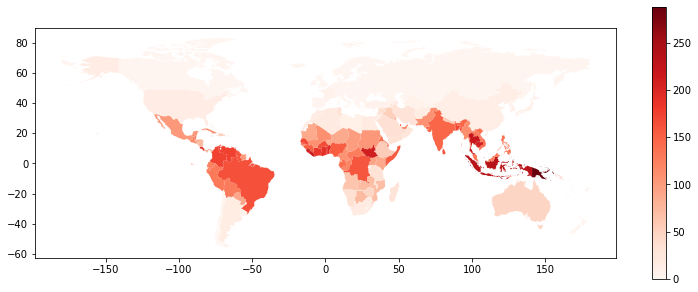

In [26]:
gdf_zonalstats.plot(column='mean_ndays_gt28',cmap='Reds',figsize=(13,5),legend=True)


In [22]:
gdf_zonalstats.dropna().sort_values('mean_ndays_gt28', ascending=False).head(20)

,name,geometry,abbreviation,region,mean_ndays_gt28
136,Papua New Guinea,"MULTIPOLYGON (((140.97446 -2.60052, 140.98732 ...",PNG,East Asia & Pacific,287.942047
77,Indonesia,"MULTIPOLYGON (((117.70361 4.16341, 117.70361 4...",IDN,East Asia & Pacific,234.560043
167,Thailand,"MULTIPOLYGON (((102.91358 11.64590, 102.90602 ...",THA,East Asia & Pacific,219.027023
97,Liberia,"POLYGON ((-11.47619 6.91942, -11.44449 6.93394...",LBR,Sub-Saharan Africa,214.915710
157,South Sudan,"POLYGON ((35.92084 4.61933, 35.85654 4.61960, ...",SSD,Sub-Saharan Africa,210.191193
91,Cambodia,"MULTIPOLYGON (((107.52039 14.70458, 107.53243 ...",KHM,East Asia & Pacific,208.722107
153,Sierra Leone,"MULTIPOLYGON (((-10.28224 8.48463, -10.28291 8...",SLE,Sub-Saharan Africa,207.697754
25,Brunei Darussalam,"MULTIPOLYGON (((115.14617 4.90851, 115.14680 4...",BRN,East Asia & Pacific,202.811081
13,Benin,"POLYGON ((3.59640 11.69577, 3.57439 11.67304, ...",BEN,Sub-Saharan Africa,198.660080
166,Togo,"POLYGON ((-0.16611 11.13498, -0.11506 11.12466...",TGO,Sub-Saharan Africa,194.935944


In [42]:
top_countries = gdf_zonalstats.dropna().sort_values('mean_ndays_gt28', ascending=False).head(50).reset_index()[['name','region','mean_ndays_gt28']]
top_countries.index = top_countries.index +1
top_countries.round(0)

,name,region,mean_ndays_gt28
1,Papua New Guinea,East Asia & Pacific,288.0
2,Indonesia,East Asia & Pacific,235.0
3,Thailand,East Asia & Pacific,219.0
4,Liberia,Sub-Saharan Africa,215.0
5,South Sudan,Sub-Saharan Africa,210.0
6,Cambodia,East Asia & Pacific,209.0
7,Sierra Leone,Sub-Saharan Africa,208.0
8,Brunei Darussalam,East Asia & Pacific,203.0
9,Benin,Sub-Saharan Africa,199.0
10,Togo,Sub-Saharan Africa,195.0


In [43]:
gdf_zonalstats.dropna().sort_values('mean_ndays_gt28', ascending=True).head(50)[['name','region','mean_ndays_gt28']]

# check the small islands !! if its a masking problem or really there is no exceedance 

,name,region,mean_ndays_gt28
82,Iceland,Europe & Central Asia,0.000000
39,Cape Verde,Sub-Saharan Africa,0.000000
79,Ireland,Europe & Central Asia,0.000000
158,São Tomé and Principe,Sub-Saharan Africa,0.000000
46,Denmark,Europe & Central Asia,0.000000
92,Kiribati,East Asia & Pacific,0.000000
20,Belarus,Europe & Central Asia,0.000000
38,Comoros,Sub-Saharan Africa,0.000000
53,Estonia,Europe & Central Asia,0.000000
181,Saint Vincent and the Grenadines,Latin America & Caribbean,0.000000


# Check e.g. Kiribas

Check if small islands appear with 0 days because small and masking problem or because no exceedance

In [44]:
GCM=datasets[0]
variable='wbgt'
dirname='output_apr24-9139513' #'output_apr24-9110516' - put them in same folder!
dir1=os.path.join(scratchdirs, dirname, 'WBGT', flags['models'], 'obsclim', GCM ) # if you always change flags metric you can also replace with fxn 
filepaths=get_filepaths(variable.upper(),dir1)
lat, lon = 1.87, -157.36

In [45]:
with xr.open_mfdataset(filepaths, engine='netcdf4') as ds:
    da_kiri = ds[str(variable)].sel(lat=lat, lon=lon, method='nearest').chunk({'time': -1}).compute()

(array([3.000e+00, 4.000e+00, 4.000e+00, 7.000e+00, 8.000e+00, 1.900e+01,
        2.900e+01, 5.500e+01, 1.180e+02, 2.150e+02, 3.980e+02, 7.150e+02,
        1.241e+03, 1.969e+03, 3.156e+03, 4.612e+03, 6.085e+03, 6.973e+03,
        7.075e+03, 5.657e+03, 3.290e+03, 1.245e+03, 3.950e+02, 1.210e+02,
        4.400e+01, 1.700e+01, 6.000e+00, 2.000e+00, 0.000e+00, 1.000e+00]),
 array([18.879202, 19.221502, 19.563805, 19.906105, 20.248407, 20.590708,
        20.93301 , 21.27531 , 21.61761 , 21.959913, 22.302214, 22.644516,
        22.986816, 23.329119, 23.67142 , 24.013721, 24.356022, 24.698322,
        25.040625, 25.382925, 25.725227, 26.067528, 26.40983 , 26.75213 ,
        27.09443 , 27.436733, 27.779034, 28.121336, 28.463636, 28.805939,
        29.14824 ], dtype=float32),
 <BarContainer object of 30 artists>)

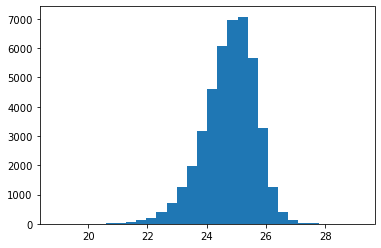

In [48]:
plt.hist(da_kiri,bins=30)